<a href="https://colab.research.google.com/github/krzysztof-kuznik/finding-c2-in-proxy/blob/main/Finding_C2_connection_in_proxy_logs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Initialize SPARK**

Install java

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Download spark

In [ ]:
!wget https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz

--2023-09-14 12:41:42--  https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299426263 (286M) [application/x-gzip]
Saving to: ‘spark-3.3.3-bin-hadoop3.tgz’

spark-3.3.3-bin-had 100%[===================>] 285.55M   225MB/s    in 1.3s    

2023-09-14 12:41:56 (225 MB/s) - ‘spark-3.3.3-bin-hadoop3.tgz’ saved [299426263/299426263]



Unpack spark

In [ ]:
!tar -xf spark-3.3.3-bin-hadoop3.tgz

Assign home variables for JAVA and SPARK

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.3-bin-hadoop3'

Install findspark

In [ ]:
!pip install -q findspark

Initiate spark session

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

## **Download data set, extract it and load to dataframe**



Download and extract anonymized dataset (5.19G)

In [ ]:
!wget http://proxy.investigation.rocks/2020-11-anonymized.tar.gz
!tar -xzvf 2020-11-anonymized.tar.gz

--2023-09-14 12:42:12--  http://proxy.investigation.rocks/2020-11-anonymized.tar.gz
Resolving proxy.investigation.rocks (proxy.investigation.rocks)... 104.21.74.86, 172.67.156.105, 2606:4700:3037::ac43:9c69, ...
Connecting to proxy.investigation.rocks (proxy.investigation.rocks)|104.21.74.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5569064266 (5.2G) [application/octet-stream]
Saving to: ‘2020-11-anonymized.tar.gz’

2020-11-anonymized. 100%[===================>]   5.19G  79.1MB/s    in 70s     

2023-09-14 12:43:22 (75.9 MB/s) - ‘2020-11-anonymized.tar.gz’ saved [5569064266/5569064266]

dbfs/mnt/temp-test/2020-11-anonymized/part-00000-tid-6804376575928431150-1372e942-c08c-4c61-a9f4-69da8e343bac-6234-1-c000.snappy.orc
dbfs/mnt/temp-test/2020-11-anonymized/part-00000-tid-8886601159411992471-bc5a212d-8080-4936-9e5a-cb8340a983c3-6235-1-c000.snappy.orc
dbfs/mnt/temp-test/2020-11-anonymized/part-00001-tid-8886601159411992471-bc5a212d-8080-4936-9e5a-cb8340a983c3

In [ ]:
!du -sh dbfs/mnt/temp-test/2020-11-anonymized/

6.1G	dbfs/mnt/temp-test/2020-11-anonymized/


Read parted ORC files into single dataframe

In [ ]:
df = spark.read.orc('dbfs/mnt/temp-test/2020-11-anonymized/*.orc')
df.count()

575890859

## Data exploration

Data from November 2020. Anonymized domains with words from dictionary but rest of the data is original. Half a billion http requests.

In [ ]:
df.count()

575890859

Show schema

In [ ]:
df.printSchema()

root
 |-- timestamp_epoch: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- source_device: string (nullable = true)
 |-- request_size: long (nullable = true)
 |-- response_size: long (nullable = true)
 |-- content_type: string (nullable = true)
 |-- request_method: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- request_url_port: string (nullable = true)
 |-- proxy_response: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- user_agent: string (nullable = true)



Data sample rows

In [ ]:
df.limit(20).show(truncate=False)

+---------------+-------------------+-------------+------------+-------------+---------------------------+--------------+--------+----------------+--------------+--------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|timestamp_epoch|timestamp          |source_device|request_size|response_size|content_type               |request_method|protocol|request_url_port|proxy_response|domain                                      |user_agent                                                                                                                         |
+---------------+-------------------+-------------+------------+-------------+---------------------------+--------------+--------+----------------+--------------+--------------------------------------------+-----------------------------------------------------------------------------------------------------------------

Amount of devices (laptops on VPN subnet + servers)

In [ ]:
df.select('source_device').distinct().count()

5952

## Standard deviation

A standard deviation (or σ) is a measure of how dispersed the data is in relation to the mean. Low, or small, standard deviation indicates data are clustered tightly around the mean, and high, or large, standard deviation indicates data are more spread out. A standard deviation close to zero indicates that data points are very close to the mean, whereas a larger standard deviation indicates data points are spread further away from the mean.

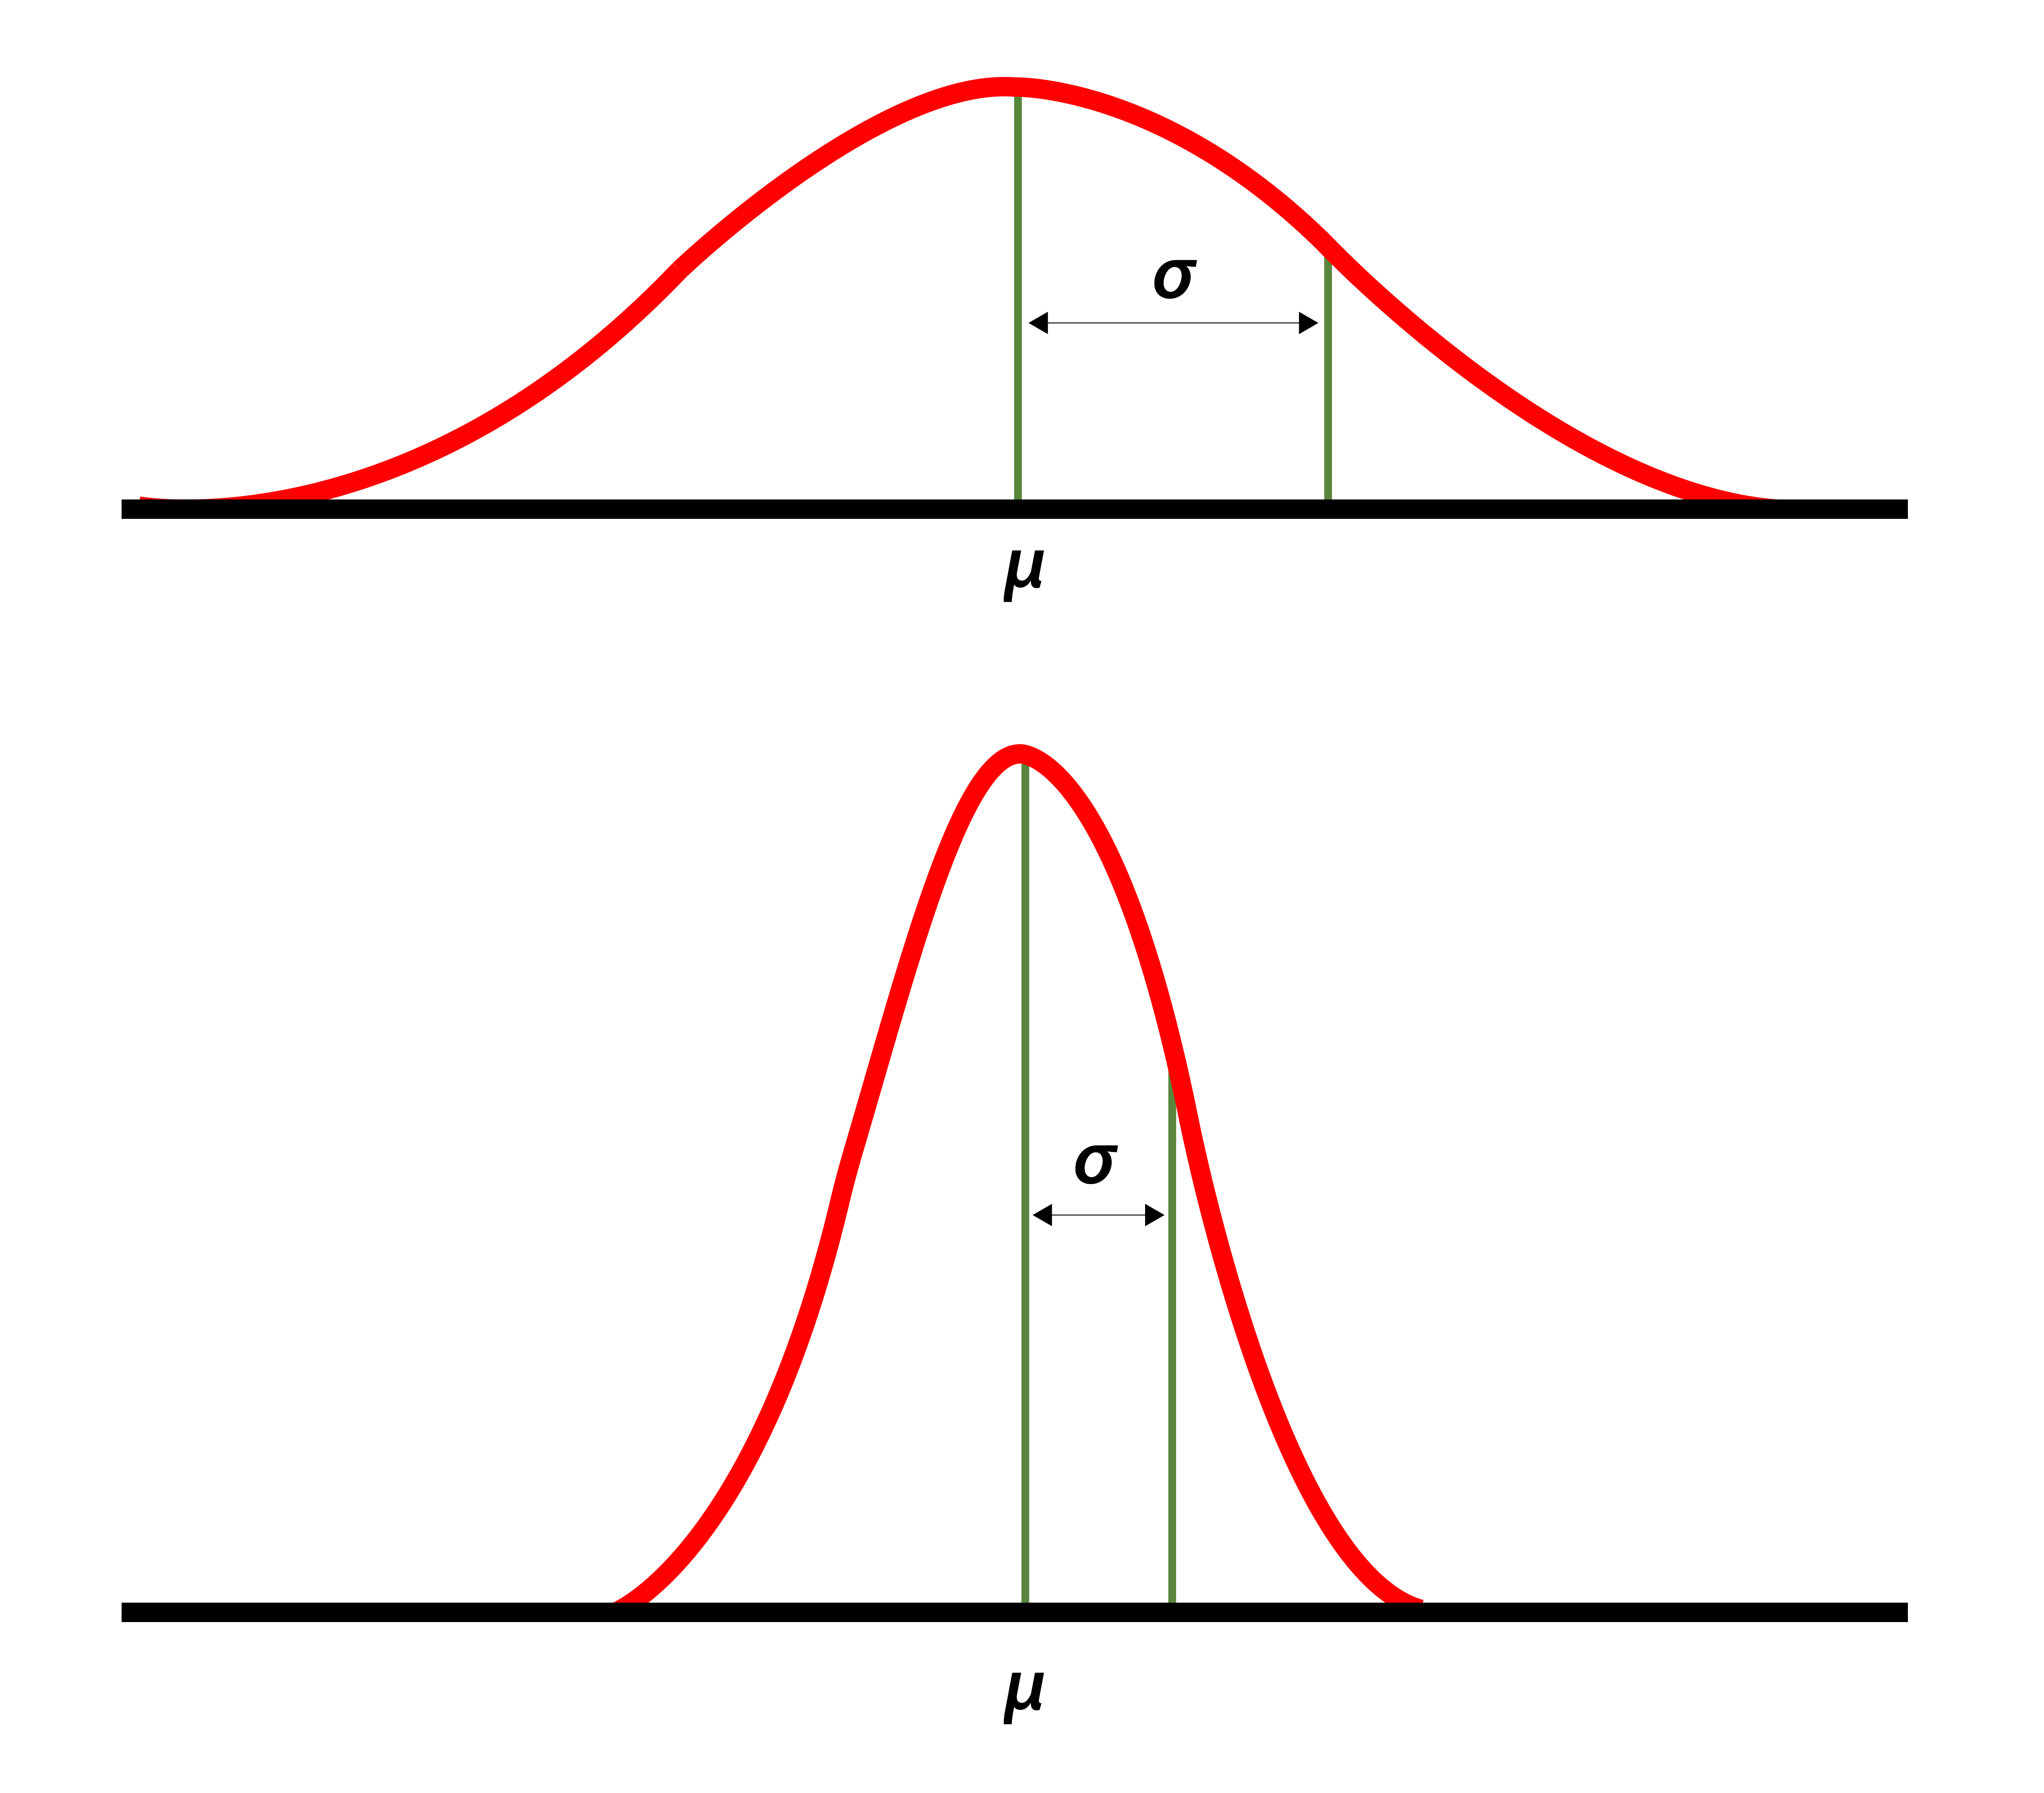

## Detecting C2

###General premise of the detection is that the attacker will at some point switch to shorter (more frequent) beaconing in further stage of the attack which will result in multiple HTTP requests having the same response size.

Import some additional counting functions

In [99]:
from pyspark.sql import functions as F

Filter out some data:


*   we're not looking for CONNECT methods as they appear when traffic is not SSL inspected and we do not see individual requests but a tunneled activity presented as one
*   response size == 39 back in the day was a bug on the proxy where it returned code 200 (success status) but returned message that it's not authorized which was exactly of size 39 bytes
*   we're interested in succesfull connections - only they provide relevant response size



In [105]:
df_filtered = df_with_dom.filter((df.request_method != 'CONNECT') & \
                        (df.response_size != 39) & \
                        (df.proxy_response.like('2%')))
df_filtered.count()

73769197

We aggregate data by domain and count some metrics:

*   standard deviation of response size
*   count of all connections to the domain
*   distinct number of source devices which connected to the particular domain (very important)


In [ ]:
df_aggregates = df_filtered.groupBy('domain').agg(stddev_pop('response_size').alias('stddev'),\
                                  count('*').alias('connections_count'),\
                                  countDistinct('source_device').alias('distinct_devices'))
df_aggregates.limit(5).show(truncate=False)

+-------------------------------+------------------+-----------------+----------------+
|domain                         |stddev            |connections_count|distinct_devices|
+-------------------------------+------------------+-----------------+----------------+
|anthonin.scrimp.eu             |281.2817915780603 |932542           |1019            |
|stof.hexameron.com             |100.23288512992993|1715743          |2669            |
|tragicolored.antisensitizer.com|77028.58261888023 |35350            |742             |
|plaguesome.radiopraxis.com     |55304.898415100986|159              |49              |
|roudas.uncoalescent.net        |17097.198039619543|1111             |197             |
+-------------------------------+------------------+-----------------+----------------+



Now we filter the aggregated metrics:


*   standard deviation has to be greater than 1 but we limit results to below 1
*   connections to the domain must only occurr from one device (infected one) - this is very powerful filter as beaconing does occur regularly but then it's usually seen on multiple hosts
*   we're interested in at least 30 connections - that's a subjective threshold observed on some experiments with C2 frameworks



In [ ]:
df_final = df_aggregates.filter((df_aggregates.stddev > 0) & \
                                (df_aggregates.stddev < 1) & \
                                (df_aggregates.distinct_devices == 1) & \
                                (df_aggregates.connections_count > 30))
df_final.show(truncate=False)

+----------------------------------------------+----------------------+-----------------+----------------+
|domain                                        |stddev                |connections_count|distinct_devices|
+----------------------------------------------+----------------------+-----------------+----------------+
|coquelicot.redstreak.net                      |0.6188017780545261    |2121             |1               |
|trafficker.waives.tc                          |0.9681197546662347    |64               |1               |
|equilater.kevel.net                           |0.5598833697790089    |245              |1               |
|barrows.abdominocentesis.lenth.com            |0.27638539919627797   |120              |1               |
|birdseye.unencouraged.net                     |0.3677985242255251    |31               |1               |
|circumstanced.balat.com                       |0.5416799421829376    |260              |1               |
|apteryx.redstreak.co                

Et voilà ! Only 15 hits for a whole month of data from almost 6 thousand devices ? I call it a win in my book.

Let's look at connections to one of the domains in results:

In [107]:
df.filter((df.domain == 'circumstanced.balat.com') & \
                        (df.request_method != 'CONNECT') & \
                        (df.response_size != 39) & \
                        (df.proxy_response.like('2%')))

timestamp_epoch,timestamp,source_device,request_size,response_size,content_type,request_method,protocol,request_url_port,proxy_response,domain,user_agent
1605703715000,2020-11-18 12:48:35,device1209,1395,235,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605705919000,2020-11-18 13:25:19,device1209,1395,235,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605705161000,2020-11-18 13:12:41,device1209,1387,235,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605705860000,2020-11-18 13:24:20,device1209,1395,235,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605705940000,2020-11-18 13:25:40,device1209,1387,235,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605697049000,2020-11-18 10:57:29,device1209,1388,234,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605699045000,2020-11-18 11:30:45,device1209,1386,234,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605697160000,2020-11-18 10:59:20,device1209,1386,234,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605698752000,2020-11-18 11:25:52,device1209,1386,234,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...
1605698763000,2020-11-18 11:26:03,device1209,1388,234,application/javas...,GET,https,443,200,circumstanced.bal...,Mozilla/5.0 (Wind...


Next step would be to focus on observed beaconing within individual day but in this simple example we only group by domain. One of the ways to do that is to group by domain,year,month,day and have a separate table for baseline in which you can note down on how many devices historically connections to particular domain were observed.